# Importing Modules

In [13]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os
import math
import imageio

# Define Neural Network

In [14]:
class FCN(nn.Module):
    "Defines a connected network"
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
        
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

# Advection equation 

$ -\left( v(x) \frac{\partial u}{\partial x} + v(y) \frac{\partial u}{\partial y} \right)$


In [15]:
mu = 0.1 
def u0(x):
    return np.exp(-100*(x-0.2)**2) # gaussian wave
def u_true(x,t):
    return  u0(x - mu * t)

# 2D advection equation 
def u_2d_true(x, y, t):
        return u0(x - mu * t) * u0(y - mu * t)

# Observational input Data

In [16]:
nx,ny,nt = 100,100,2

xrmeshshape: (100, 100, 2) 
 yrmeshshape: (100, 100, 2) 
 trmeshshape: (100, 100, 2)


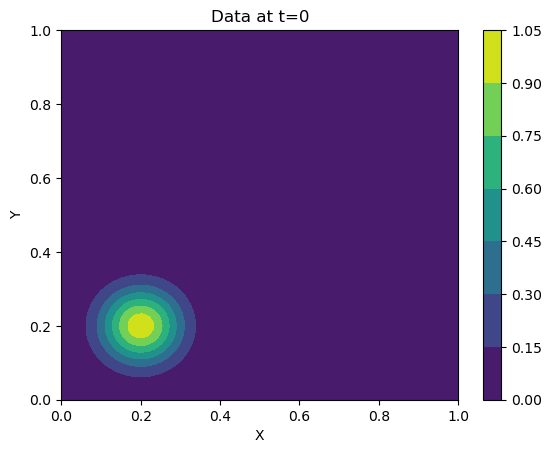

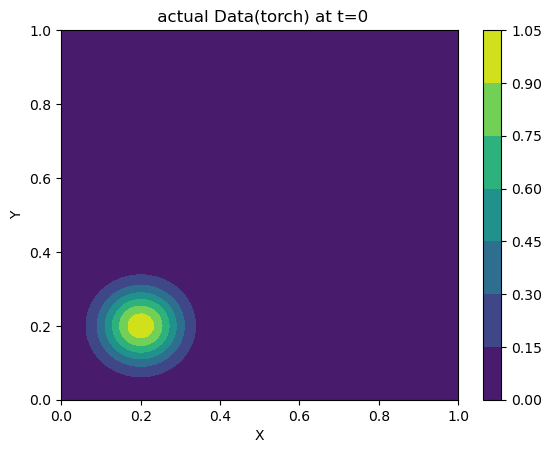

rin_data shape: torch.Size([20000, 3]) 
 rout_data shape: torch.Size([20000, 1])


In [17]:
xr = np.linspace(0,1,nx)
yr = np.linspace(0,1,ny)
tr = np.linspace(0,nt-1,nt).T
# print(f'xr: {xr} \n yr: {yr} \n tr: {tr}')
# print(f'xrshape: {xr.shape} \n yrshape: {yr.shape} \n trshape: {tr.shape}')
xrmesh , yrmesh, trmesh = np.meshgrid(xr,yr,tr)
# print(f'xrmesh: {xrmesh} \n yrmesh: {yrmesh} \n trmesh: {trmesh}')
print(f'xrmeshshape: {xrmesh.shape} \n yrmeshshape: {yrmesh.shape} \n trmeshshape: {trmesh.shape}')

ur = u_2d_true(xrmesh,yrmesh,trmesh)

#print(ur[:,:,0].shape)
# print(ur[0,:,:].shape)
# print(xrmesh[0,:,:].shape)
#plot ur
plt.contourf(xrmesh[:,:,0], yrmesh[:,:,0], ur[:,:,0])
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Data at t=0')
plt.colorbar()
plt.show()

# Stack the 3 2D arrays along a new third dimension, then reshape into a 2D array
rin_data = np.stack((xrmesh, yrmesh, trmesh), axis=-1).reshape(-1, 3)
rin_data = torch.tensor(rin_data).float()
rout_data = torch.tensor(ur).float().reshape(-1,1)

rout_data2 = rout_data.numpy().reshape(nx,ny,nt)
plt.contourf(xrmesh[:,:,0], yrmesh[:,:,0], rout_data2[:,:,0])
plt.xlabel('X')
plt.ylabel('Y')
plt.title(' actual Data(torch) at t=0')
plt.colorbar()
plt.show()
print(f'rin_data shape: {rin_data.shape} \n rout_data shape: {rout_data.shape}')

# Fitting a Neural Network to the observational data

In [18]:
torch.manual_seed(123)
model = FCN(3,1,32,3)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
for i in range(5000):
    optimizer.zero_grad()
    uh = model(rin_data)
    
    loss = torch.mean((uh-rout_data)**2)
    loss.backward()
    optimizer.step()
    if (i+1) % 1000 == 0:
        print(f'Epoch: {i+1}/{10000}, Loss: {loss.item()}')
        

print(uh.shape, rout_data.shape, rin_data.shape)

Epoch: 1000/10000, Loss: 0.0066820005886256695
Epoch: 2000/10000, Loss: 0.00013997789938002825
Epoch: 3000/10000, Loss: 3.810217822319828e-05
Epoch: 4000/10000, Loss: 2.1778494556201622e-05
Epoch: 5000/10000, Loss: 1.3925877283327281e-05
torch.Size([20000, 1]) torch.Size([20000, 1]) torch.Size([20000, 3])


To check the behavior of the fitted model, we plot model output as a function of x and y for times between t=0 and t=3, and compare it to observed data and the true function.

torch.Size([100000, 1])


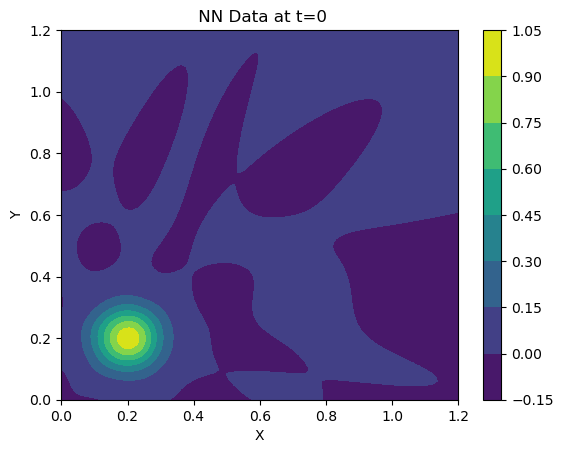

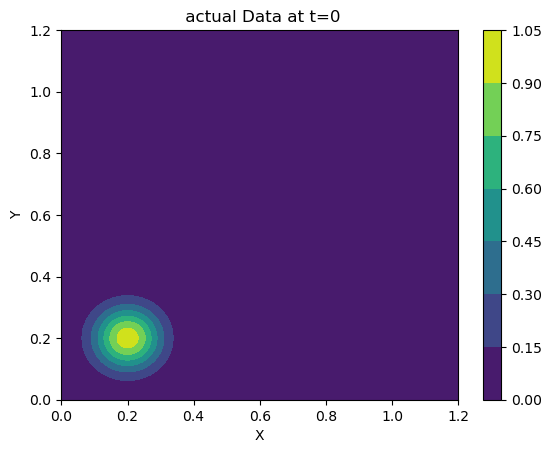

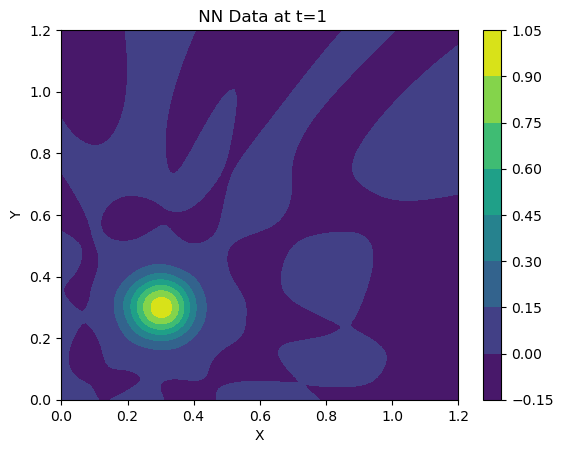

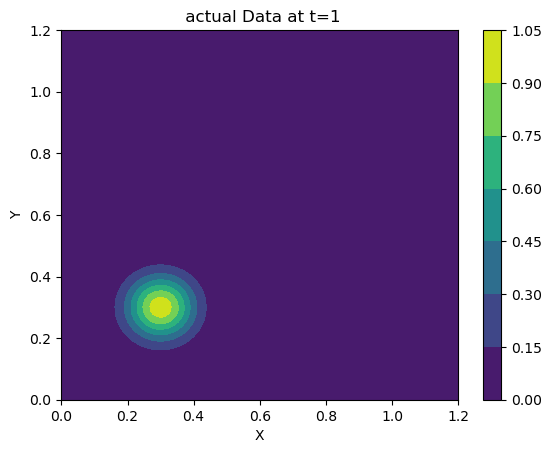

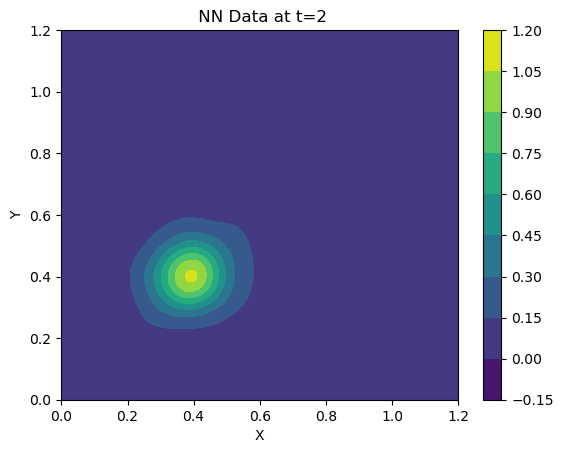

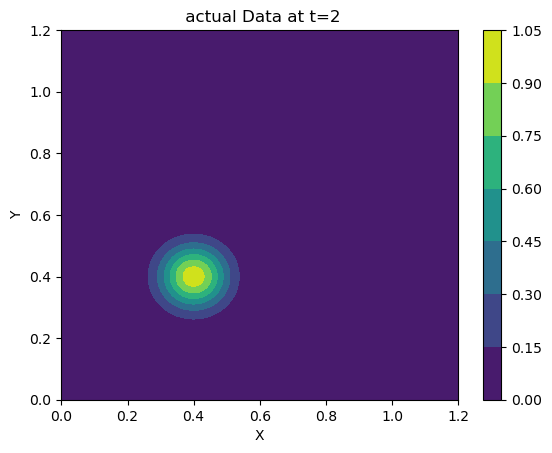

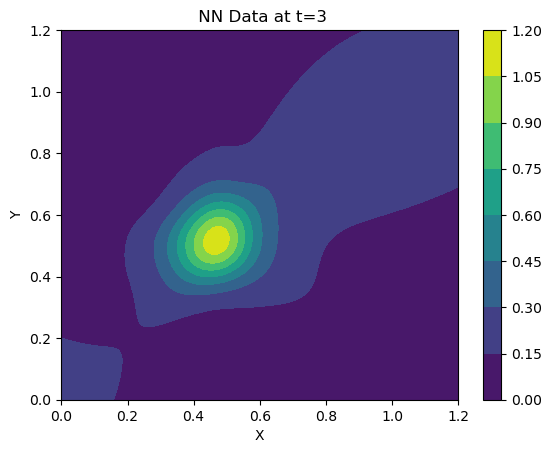

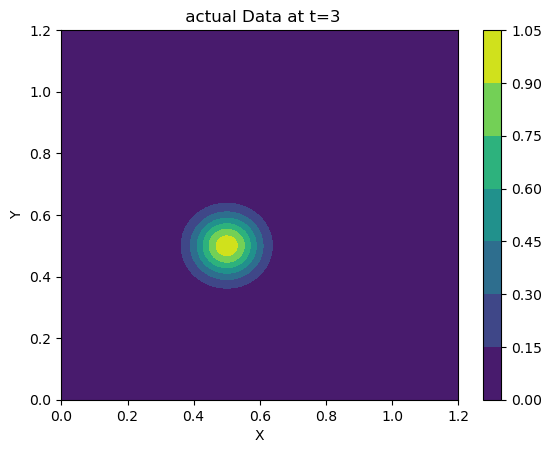

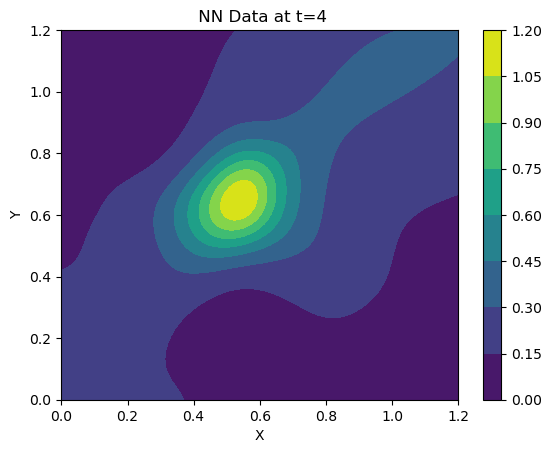

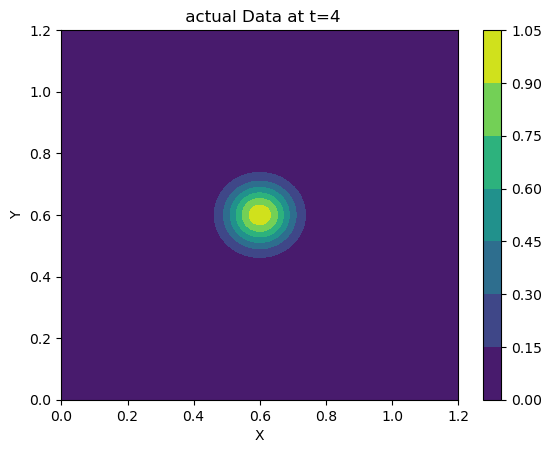

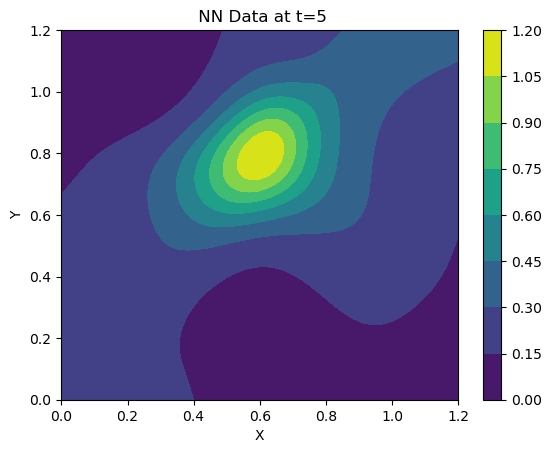

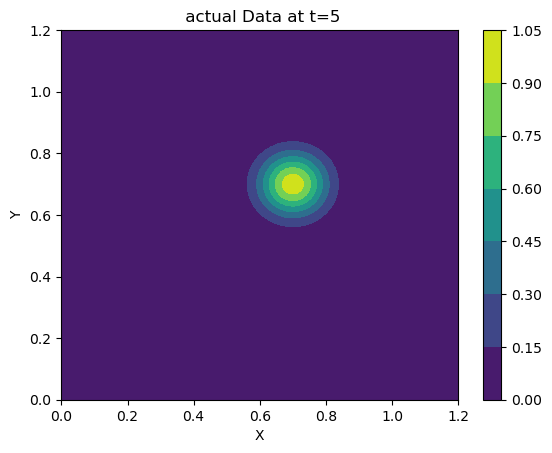

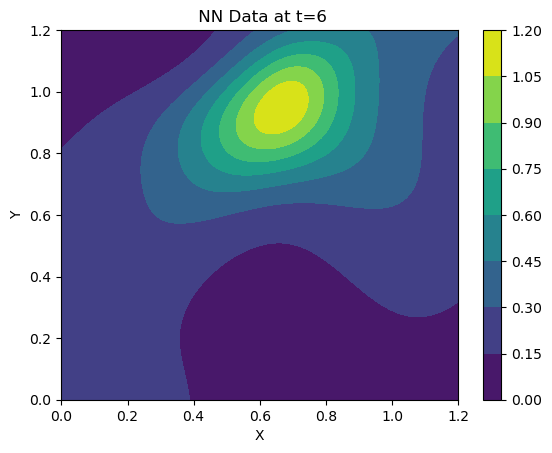

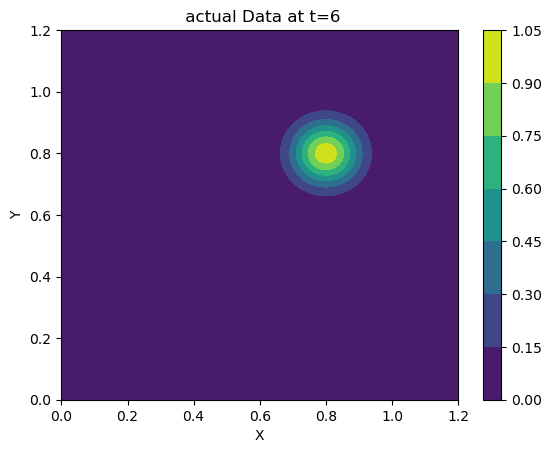

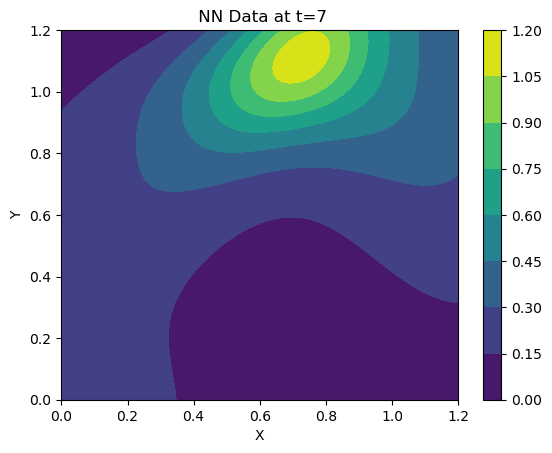

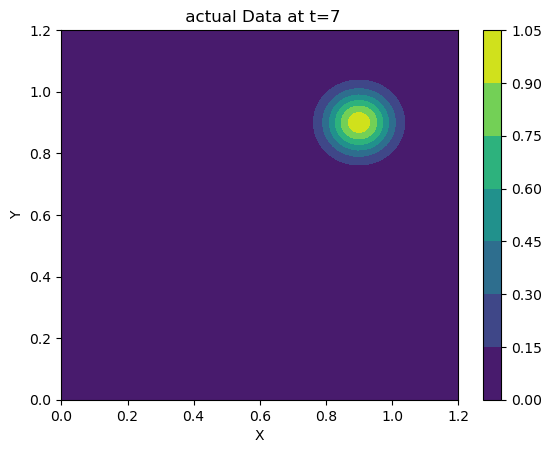

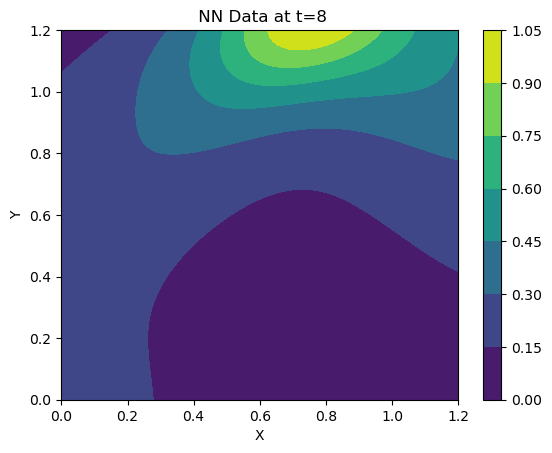

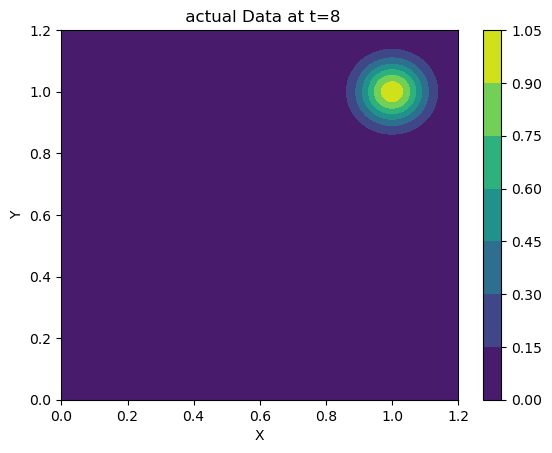

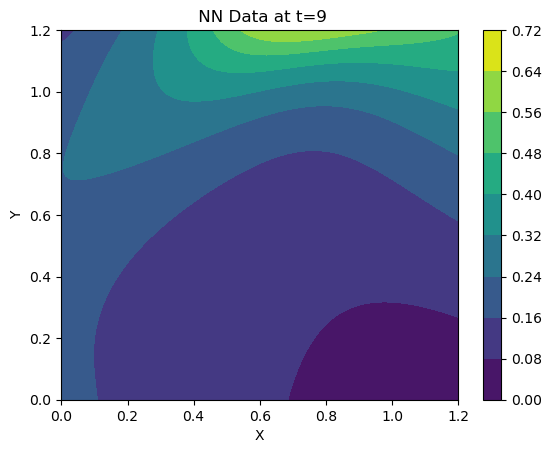

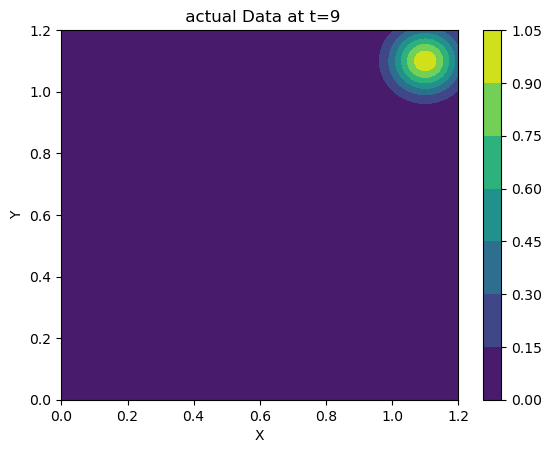

In [19]:
'''
Generate and save the plots for tt = 0-11
'''
cwd = os.getcwd()
true_plot_dir = os.path.join(cwd, '2d-advection', 'true_plot')
nn_plot_dir = os.path.join(cwd, '2d-advection', 'nn_plot')

# Create the directories if they don't exist
os.makedirs(nn_plot_dir, exist_ok=True)
os.makedirs(true_plot_dir, exist_ok=True)


nt = 10
xr = np.linspace(0,1.2,nx)
yr = np.linspace(0,1.2,ny)
tr = np.linspace(0,nt-1,nt).T
# print(f'xr: {xr} \n yr: {yr} \n tr: {tr}')
# print(f'xrshape: {xr.shape} \n yrshape: {yr.shape} \n trshape: {tr.shape}')
xrmesh , yrmesh, trmesh = np.meshgrid(xr,yr,tr)
# print(f'xrmesh: {xrmesh} \n yrmesh: {yrmesh} \n trmesh: {trmesh}')
#print(f'xrmeshshape: {xrmesh.shape} \n yrmeshshape: {yrmesh.shape} \n trmeshshape: {trmesh.shape}')


rin_test = np.stack((xrmesh, yrmesh, trmesh), axis=-1).reshape(-1, 3)
rin_test = torch.tensor(rin_test).float()
print(model(rin_test.float()).shape)

for tt in range(nt):
    ur = model(rin_test.float()).detach().numpy().reshape(nx,ny,nt)
    ut = u_2d_true(xrmesh,yrmesh,trmesh)
    plt.contourf(xrmesh[:,:,0], yrmesh[:,:,0], ur[:,:,tt])
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(' NN Data at t='+str(tt))
    plt.savefig(nn_plot_dir + '/nn_plot_{}.png'.format(tt))
    plt.colorbar()
    plt.show()

    plt.contourf(xrmesh[:,:,0], yrmesh[:,:,0], ut[:,:,tt])
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(' actual Data at t='+str(tt))
    plt.savefig(true_plot_dir + '/true_plot_{}.png'.format(tt))
    plt.colorbar()
    plt.show()




# Save GIFs

In [20]:
'''
Saves the plots as a GIF
'''
for _ in ['nn_plot', 'true_plot']:
    # Set the directories for the images
    plot_dir = os.path.join(cwd, '2d-advection', _)

    # Get the list of image files
    plot_files = sorted([os.path.join(plot_dir, file) for file in os.listdir(plot_dir)])

    # Create a list to store the images
    images = []

    # Read and append the images to the list
    for file in plot_files:
        images.append(imageio.imread(file))

    # Set the output file path
    output_file = os.path.join(cwd, "2d{}.gif".format(_))

    # Save the images as a GIF
    imageio.mimsave(output_file, images, duration=1, loop=10, fps=1, subrectangles=True, palettesize=256)

/tmp/ipykernel_7703/1479581684.py:16: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(file))


# Adding physics to the loss function

We generate a random selection of points over that (x,y)-t domain $(0,1) \times (0,5)$ at which the physical constraint will be enforced.

In [21]:
# nx,ny,nt = 10,10,2
nx,ny,nt = 100,100,2


# randomly sample points in (x,y)-t space, where x in [0,1] and t in [0,5]
np.random.seed(123)
rin_physics = np.random.uniform(size=(nx*ny*nt,3))
rin_physics[:,2] *= nt
rin_physics = torch.tensor(rin_physics).float().requires_grad_(True)
print(f'input tensor shape :{rin_data.shape}')
print(f'input tensor physics shape : {rin_physics.shape}')

# Input observations to the network : rin_data

xr = np.linspace(0,1,nx)
yr = np.linspace(0,1,ny)
tr = np.linspace(0,nt-1,nt).T
# print(f'xr: {xr} \n yr: {yr} \n tr: {tr}')
# print(f'xrshape: {xr.shape} \n yrshape: {yr.shape} \n trshape: {tr.shape}')
xrmesh , yrmesh, trmesh = np.meshgrid(xr,yr,tr)
# print(f'xrmesh: {xrmesh} \n yrmesh: {yrmesh} \n trmesh: {trmesh}')
print(f'xrmeshshape: {xrmesh.shape} \n yrmeshshape: {yrmesh.shape} \n trmeshshape: {trmesh.shape}')

ur = u_2d_true(xrmesh,yrmesh,trmesh)

#print(ur[:,:,0].shape)
# print(ur[0,:,:].shape)
# print(xrmesh[0,:,:].shape)

# Stack the 3 2D arrays along a new third dimension, then reshape into a 2D array
rin_data = np.stack((xrmesh, yrmesh, trmesh), axis=-1).reshape(-1, 3)
rin_data = torch.tensor(rin_data).float()


input tensor shape :torch.Size([20000, 3])
input tensor physics shape : torch.Size([20000, 3])
xrmeshshape: (100, 100, 2) 
 yrmeshshape: (100, 100, 2) 
 trmeshshape: (100, 100, 2)


# Fitting a PINN 

In [22]:
torch.manual_seed(123)
pinn = FCN(3,1,32,3)
#mu = torch.tensor(np.linspace(0.1, 0.5, 100).reshape(100,1)).float()
optimizer = torch.optim.Adam(pinn.parameters(), lr=1e-3)
for i in range(5000):
    optimizer.zero_grad()
    
    # compute the "data loss"
    uh = pinn(rin_data)
    loss1 = torch.mean((uh-rout_data)**2) # use mean squared error
    
    # compute the "physics loss"
    uhp = pinn(rin_physics)
    grad = torch.autograd.grad(outputs=uhp, inputs=rin_physics, 
                               grad_outputs=torch.ones_like(uhp), create_graph=True)[0]
    dudx = grad[:, 0]
    dudy = grad[:, 1]
    dudt = grad[:, 2]
    physics = dudt + mu *( dudx + dudy) # this term is zero if the model output satisfies the advection equation
    loss2 = torch.mean((physics)**2)
    
    # backpropagate combined loss
    loss = 2*loss1 + loss2 # add two loss terms together
    loss.backward()
    optimizer.step()

    if (i+1) % 1000 == 0:
            print(f'Epoch: {i+1}/{10000}, Loss: {loss.item()}')
            print(f' NN loss : {loss1.item()}, Physics loss : {loss2.item()}')

Epoch: 1000/10000, Loss: 0.013464488089084625
 NN loss : 0.006680496968328953, Physics loss : 0.00010349457443226129
Epoch: 2000/10000, Loss: 0.0003349397156853229
 NN loss : 0.00015578654711134732, Physics loss : 2.336662873858586e-05
Epoch: 3000/10000, Loss: 6.60381920170039e-05
 NN loss : 2.9161825295886956e-05, Physics loss : 7.714545063208789e-06
Epoch: 4000/10000, Loss: 3.0320674341055565e-05
 NN loss : 1.3106621736369561e-05, Physics loss : 4.107430868316442e-06
Epoch: 5000/10000, Loss: 1.9259077816968784e-05
 NN loss : 8.419675395998638e-06, Physics loss : 2.419727252345183e-06


To check the behavior of the fitted model, we plot model output as a function of x and y for times between t=0 and t=3, and compare it to observed data and the true function.

torch.Size([100000, 1])


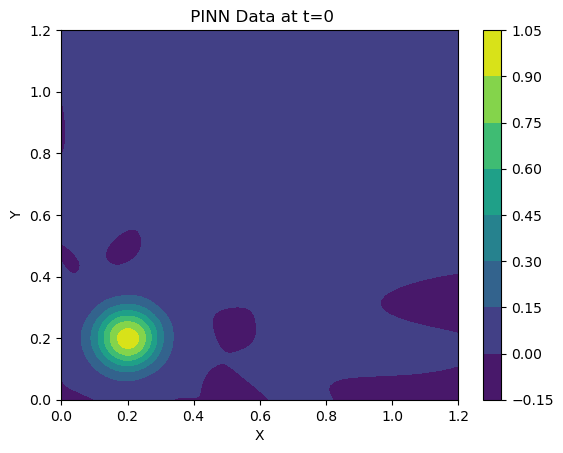

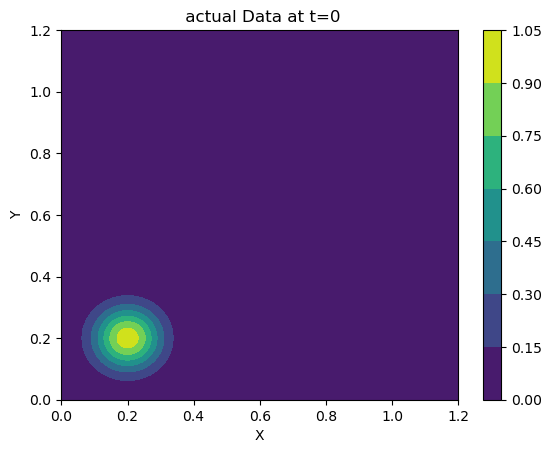

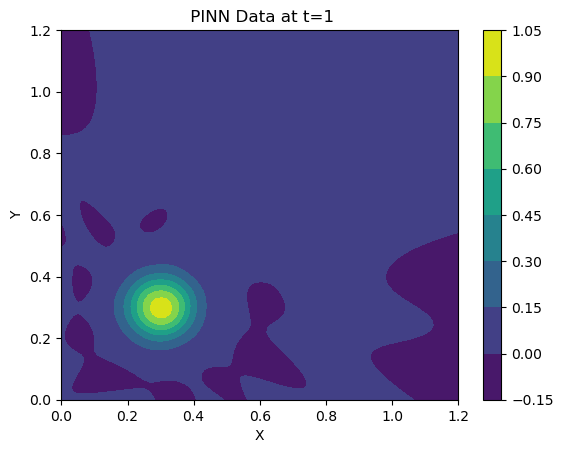

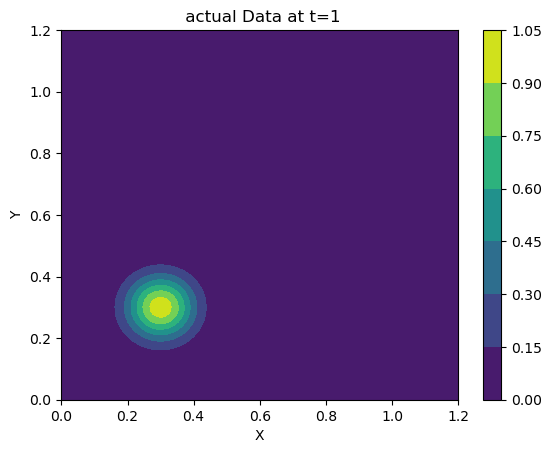

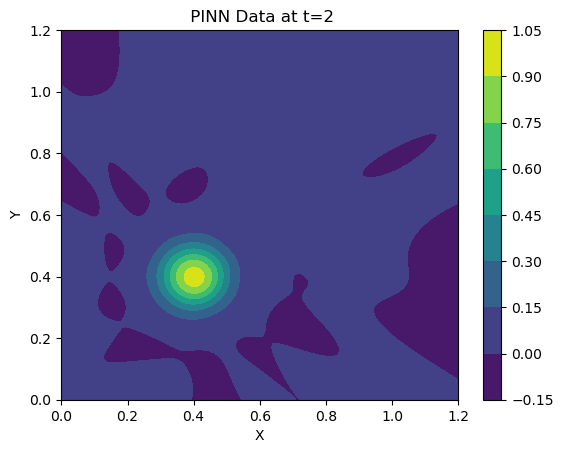

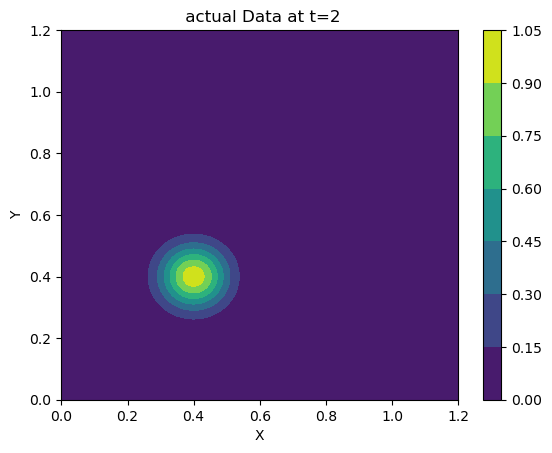

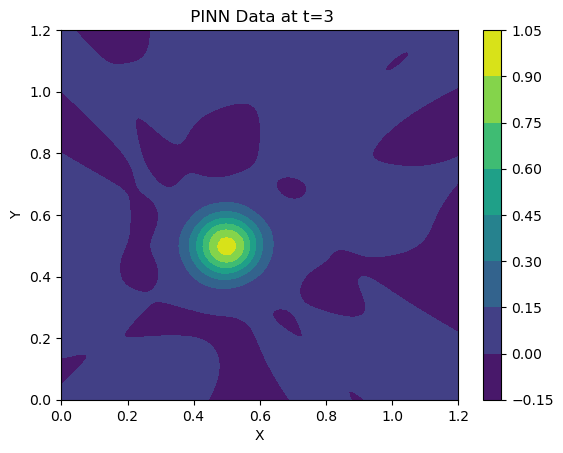

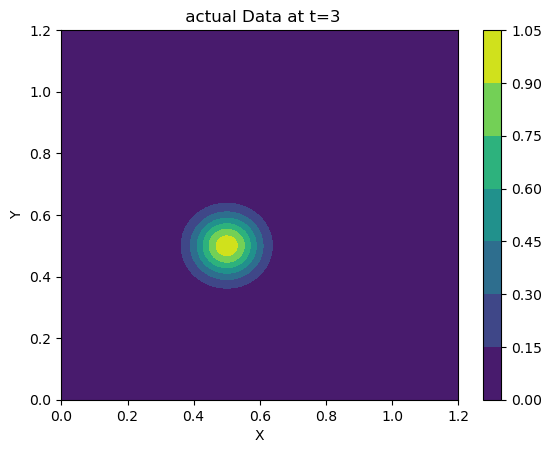

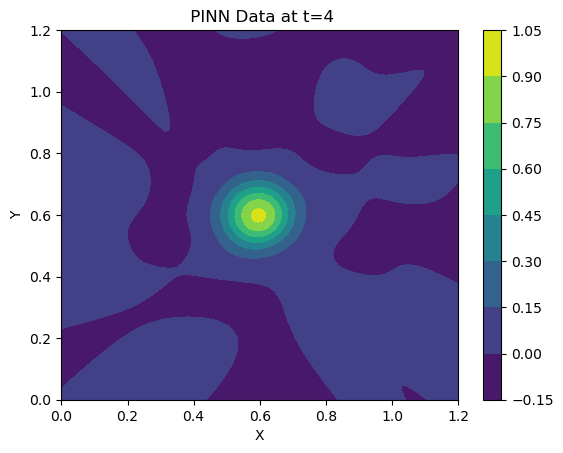

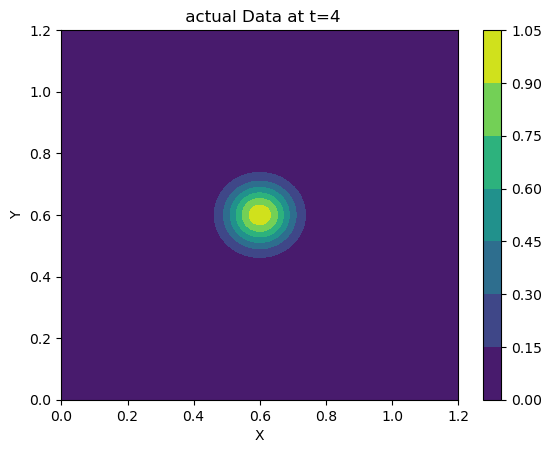

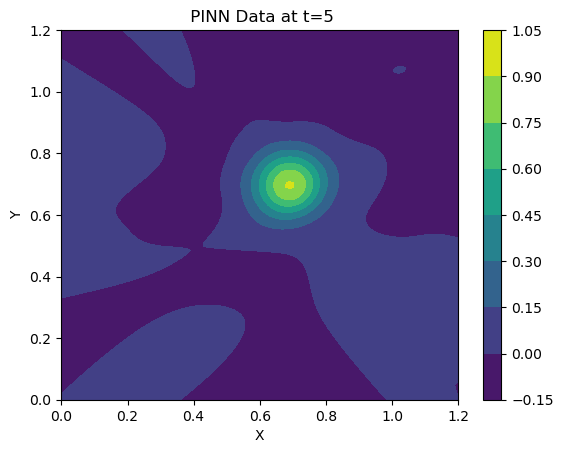

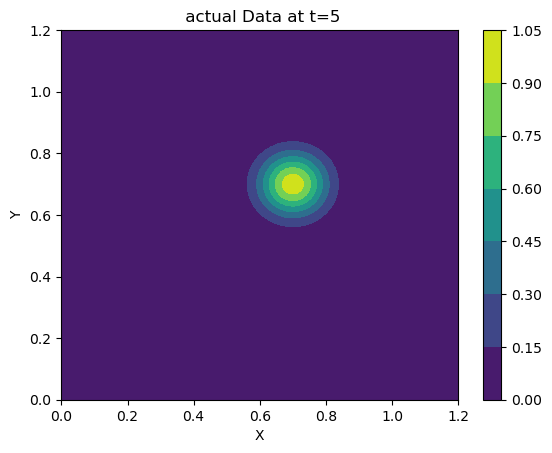

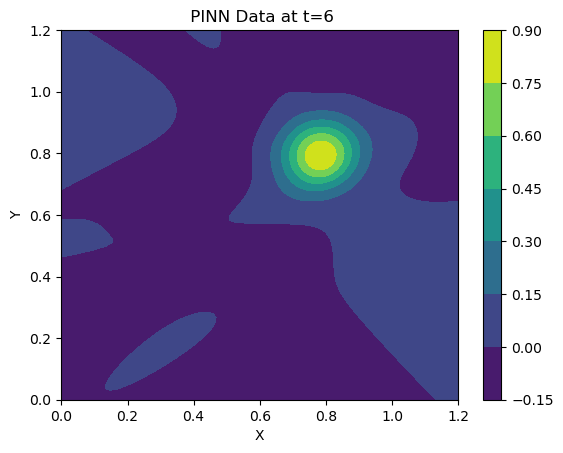

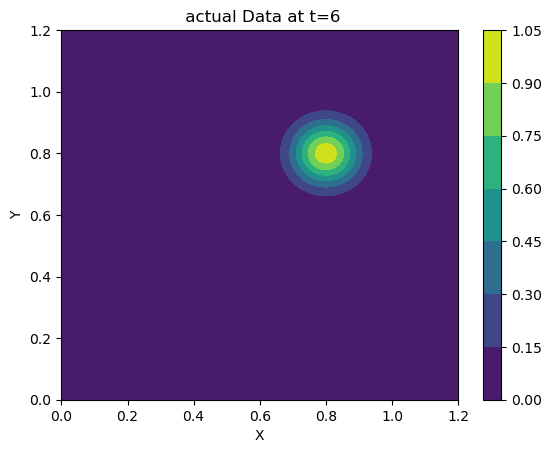

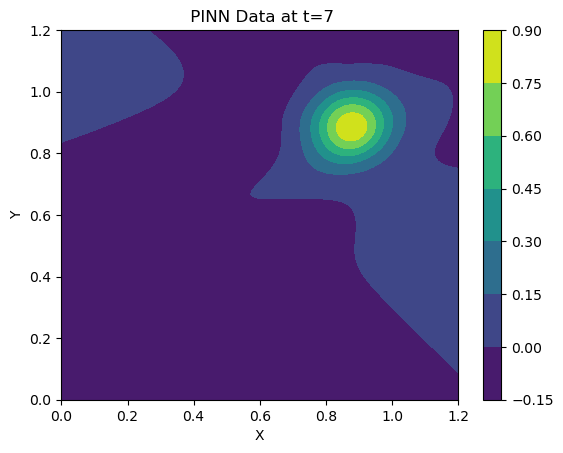

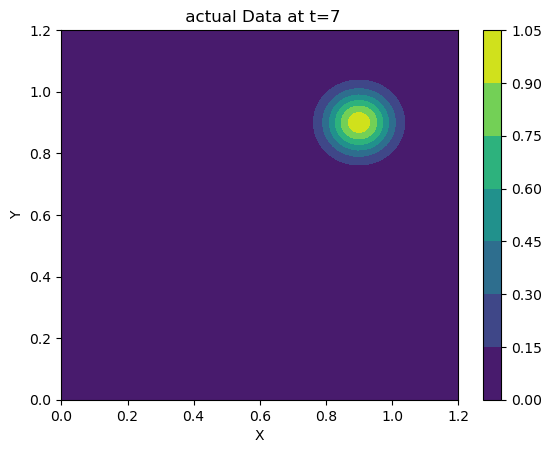

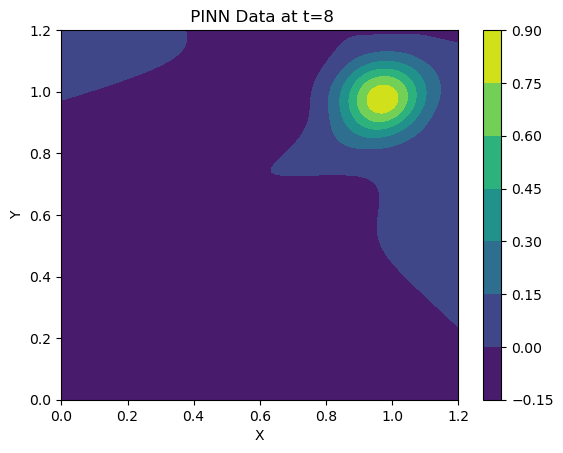

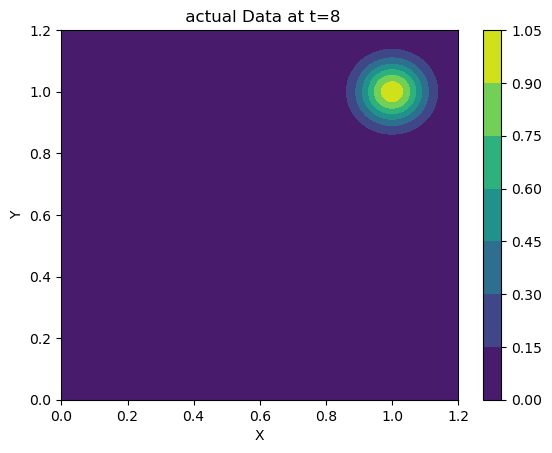

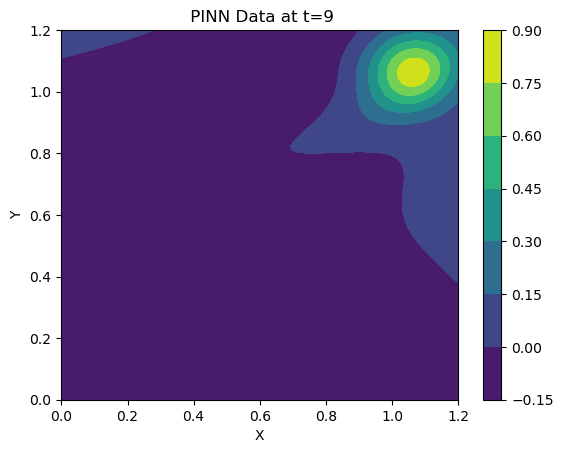

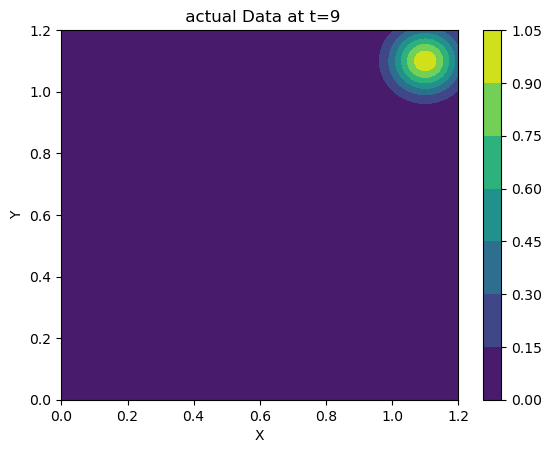

In [23]:
'''
Generate and save the plots for tt = 0-11
'''
cwd = os.getcwd()
true_plot_dir = os.path.join(cwd, '2d-advection', 'true_plot')
nn_plot_dir = os.path.join(cwd, '2d-advection', 'pinn_plot')

# Create the directories if they don't exist
os.makedirs(nn_plot_dir, exist_ok=True)
os.makedirs(true_plot_dir, exist_ok=True)


nt = 10
xr = np.linspace(0,1.2,nx)
yr = np.linspace(0,1.2,ny)
tr = np.linspace(0,nt-1,nt).T
# print(f'xr: {xr} \n yr: {yr} \n tr: {tr}')
# print(f'xrshape: {xr.shape} \n yrshape: {yr.shape} \n trshape: {tr.shape}')
xrmesh , yrmesh, trmesh = np.meshgrid(xr,yr,tr)
# print(f'xrmesh: {xrmesh} \n yrmesh: {yrmesh} \n trmesh: {trmesh}')
#print(f'xrmeshshape: {xrmesh.shape} \n yrmeshshape: {yrmesh.shape} \n trmeshshape: {trmesh.shape}')


rin_test = np.stack((xrmesh, yrmesh, trmesh), axis=-1).reshape(-1, 3)
rin_test = torch.tensor(rin_test).float()
print(model(rin_test.float()).shape)

for tt in range(nt):
    ur = pinn(rin_test.float()).detach().numpy().reshape(nx,ny,nt)
    ut = u_2d_true(xrmesh,yrmesh,trmesh)
    plt.contourf(xrmesh[:,:,0], yrmesh[:,:,0], ur[:,:,tt])
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(' PINN Data at t='+str(tt))
    plt.savefig(nn_plot_dir + '/pinn_plot_{}.png'.format(tt))
    plt.colorbar()
    plt.show()

    plt.contourf(xrmesh[:,:,0], yrmesh[:,:,0], ut[:,:,tt])
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(' actual Data at t='+str(tt))
    plt.savefig(true_plot_dir + '/true_plot_{}.png'.format(tt))
    plt.colorbar()
    plt.show()




# Save as GIFs

In [24]:
'''
Saves the plots as a GIF
'''
for _ in ['pinn_plot', 'true_plot']:
    # Set the directories for the images
    plot_dir = os.path.join(cwd, '2d-advection', _)

    # Get the list of image files
    plot_files = sorted([os.path.join(plot_dir, file) for file in os.listdir(plot_dir)])

    # Create a list to store the images
    images = []

    # Read and append the images to the list
    for file in plot_files:
        images.append(imageio.imread(file))

    # Set the output file path
    output_file = os.path.join(cwd, "2d{}.gif".format(_))

    # Save the images as a GIF
    imageio.mimsave(output_file, images, duration=1, loop=10, fps=1, subrectangles=True, palettesize=256)


/tmp/ipykernel_7703/3618420498.py:16: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(file))
